## Importation des librairies

In [1]:
# Importer les librairies
import os
import numpy as np  # Pour les opérations mathématiques et les tableaux multidimensionnels
from PIL import Image  # Pour le traitement d'images
from tensorflow.keras import layers, models  # Pour la création de modèles de réseaux de neurones
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  # Pour le contrôle des points de sauvegarde et l'arrêt anticipé durant l'entraînement
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  # Pour la génération de lots d'images avec augmentation
import matplotlib.pyplot as plt  # Pour la visualisation des données et des résultats
import pandas as pd  # Pour la manipulation et l'analyse de données
import cv2  # Pour le traitement d'images avec OpenCV
import shutil  # Pour les opérations de copie de fichiers
import random
from matplotlib.image import imread
import scipy
import json


## Paramètres et création des labels pour les panneaux de signalisation

In [2]:
# Chemins vers les dossiers
original_train_dir = '../data/gtsrb_original/Images' # Dossier contenant les images du dataset GTSRB
new_train_dir = '../data/gtsrb_split/Images_Train' # Dossier contenant les images d'entraînement
new_test_dir = '../data/gtsrb_split/Images_Test' # Dossier contenant les images de validation

# Paramètres des images
IMG_SIZE = (32, 32)  # Taille des images après redimensionnement
NUM_CLASSES = 43  # Nombre total de classes de panneaux de signalisation (fourni par le dataset GTSRB)

# Liste des labels pour les classes
classes_label = {
    0: 'Limite de vitesse (20km/h)',
    1: 'Limite de vitesse (30km/h)',
    2: 'Limite de vitesse (50km/h)',
    3: 'Limite de vitesse (60km/h)',
    4: 'Limite de vitesse (70km/h)',
    5: 'Limite de vitesse (80km/h)',
    6: 'Fin de limite de vitesse (80km/h)',
    7: 'Limite de vitesse (100km/h)',
    8: 'Limite de vitesse (120km/h)',
    9: 'Dépassement interdit',
    10: 'Dépassement interdit pour les véhicules de plus de 3.5 tonnes',
    11: 'Priorité à droite',
    12: 'Route prioritaire',
    13: 'Cédez le passage',
    14: 'Stop',
    15: 'Interdiction de circuler (tous véhicules)',
    16: 'Interdiction de circuler (véhicules de plus de 3.5 tonnes)',
    17: 'Entrée interdite',
    18: 'Attention',
    19: 'Virage dangereux à gauche',
    20: 'Virage dangereux à droite',
    21: 'Succession de virages',
    22: 'Route glissante',
    23: 'Chaussée glissante (danger)',
    24: 'Rétrécissement de la chaussée à droite',
    25: 'Travaux',
    26: 'Feux de signalisation',
    27: 'Passage piétons',
    28: 'Passage d’enfants',
    29: 'Passage d’animaux',
    30: 'Ralentisseur',
    31: 'Fin d’interdiction de dépasser',
    32: 'Fin de toutes les interdictions',
    33: 'Virage obligatoire à droite',
    34: 'Virage obligatoire à gauche',
    35: 'Direction obligatoire tout droit',
    36: 'Direction obligatoire droite ou gauche',
    37: 'Contournement par la droite',
    38: 'Contournement par la gauche',
    39: 'Direction obligatoire tout droit ou droite',
    40: 'Direction obligatoire tout droit ou gauche',
    41: 'Rond-point',
    42: 'Fin de route prioritaire'
}

## Séparation des données en validation et entraînement

In [3]:
# Créer les dossiers s'ils n'existent pas déjà
os.makedirs(new_train_dir, exist_ok=True)
os.makedirs(new_test_dir, exist_ok=True)

# Obtenir la liste des classes
classes = [d for d in os.listdir(original_train_dir) if os.path.isdir(os.path.join(original_train_dir, d))]

# Proportion de l'ensemble de validation
proportion_validation = 0.2
"""
# Diviser les images pour chaque classe
for class_name in classes:
    print(f'Séparation de la classe {class_name}')

    # Chemins pour chaque classe
    chemin_classe_source = os.path.join(original_train_dir, class_name)
    chemin_classe_entrainement = os.path.join(new_train_dir, class_name)
    chemin_classe_validation = os.path.join(new_test_dir, class_name)

    # Créer des dossiers pour chaque classe dans les ensembles d'entraînement et de validation
    os.makedirs(chemin_classe_entrainement, exist_ok=True)
    os.makedirs(chemin_classe_validation, exist_ok=True)

    # Obtenir une liste de toutes les images dans le dossier de classe
    images = os.listdir(chemin_classe_source)
    np.random.shuffle(images)  # Mélanger aléatoirement les images

    # Point de séparation pour la validation
    point_separation = int(len(images) * proportion_validation)

    # Séparer les images
    for i, img in enumerate(images):
        source_img_path = os.path.join(chemin_classe_source, img)
        if i < point_separation:
            shutil.copy(source_img_path, chemin_classe_validation)
        else:
            shutil.copy(source_img_path, chemin_classe_entrainement)
"""
print(f'Images copié dans le dossier {new_train_dir} pour l\'entraînement et dans le dossier {new_test_dir} pour la validation.')

Images copié dans le dossier ../data/gtsrb_split/Images_Train pour l'entraînement et dans le dossier ../data/gtsrb_split/Images_Test pour la validation.


## Visualisation des données

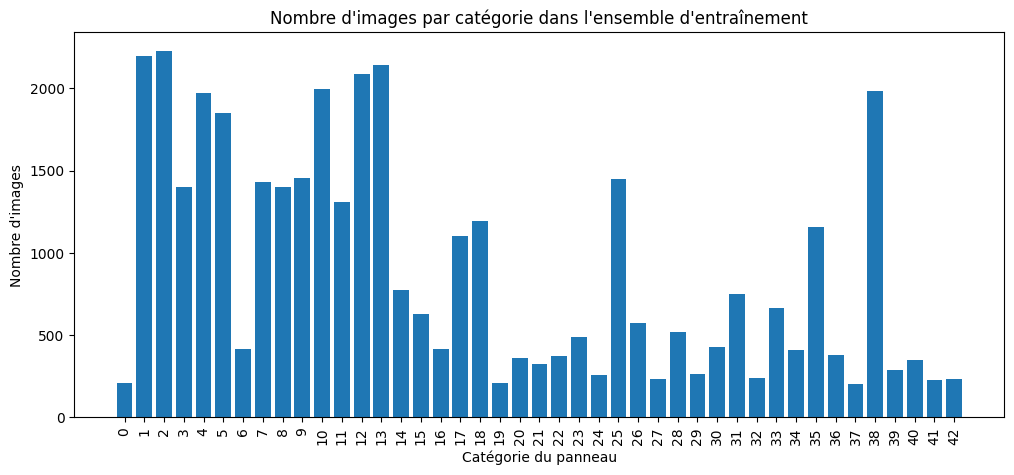

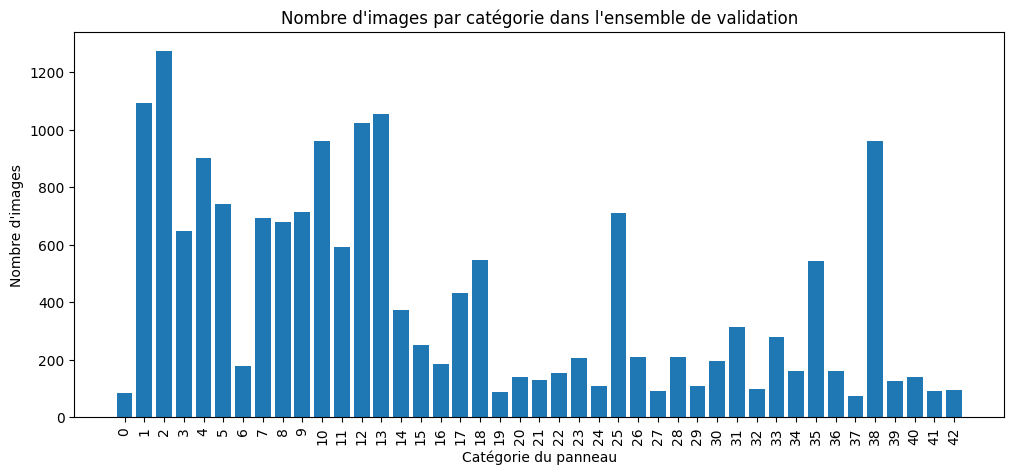

In [4]:
# Variable contenant le nombre d'images pour chaque classe dans l'ensemble d'entraînement et de validation
train_counts = {}
test_counts = {}

# On compte le nombre d'image dans les répertoires d'entraînement et de validation
for classe in classes:
    chemin_classe_entrainement = os.path.join(new_train_dir, classe)
    chemin_classe_validation = os.path.join(new_test_dir, classe)
    train_counts[classe] = len(os.listdir(chemin_classe_entrainement)) # Compte les images dans le répertoire d'entraînement
    test_counts[classe] = len(os.listdir(chemin_classe_validation)) # Compte les images dans le répertoire de validation

train_counts_sorted = dict(sorted(train_counts.items(), key=lambda item: item[1]))
test_counts_sorted = dict(sorted(test_counts.items(), key=lambda item: item[1]))

train_counts_sorted_int_keys = {int(key): value for key, value in train_counts_sorted.items()}

# Obtenez les noms des classes dans l'ordre trié
class_names = [classes_label[class_num] for class_num in train_counts_sorted_int_keys.keys()]
class_numbers = list(train_counts_sorted_int_keys.keys())

# Graphique pour l'ensemble d'entraînement avec les noms de classe
plt.figure(figsize=(12,5))
plt.bar(class_numbers, train_counts_sorted_int_keys.values())
plt.title('Nombre d\'images par catégorie dans l\'ensemble d\'entraînement')
plt.xlabel('Catégorie du panneau')
plt.ylabel('Nombre d\'images')
plt.xticks(class_numbers, rotation='vertical')
plt.show()

# Obtenez les noms des classes dans l'ordre trié pour l'ensemble de validation
test_counts_sorted_int_keys = {int(key): value for key, value in test_counts_sorted.items()}

# Graphique pour l'ensemble de validation avec les noms de classe
plt.figure(figsize=(12,5))
plt.bar(class_numbers, test_counts_sorted_int_keys.values())
plt.title('Nombre d\'images par catégorie dans l\'ensemble de validation')
plt.xlabel('Catégorie du panneau')
plt.ylabel('Nombre d\'images')
plt.xticks(class_numbers, rotation='vertical')
plt.show()



# Affichage de quelques images du dataset

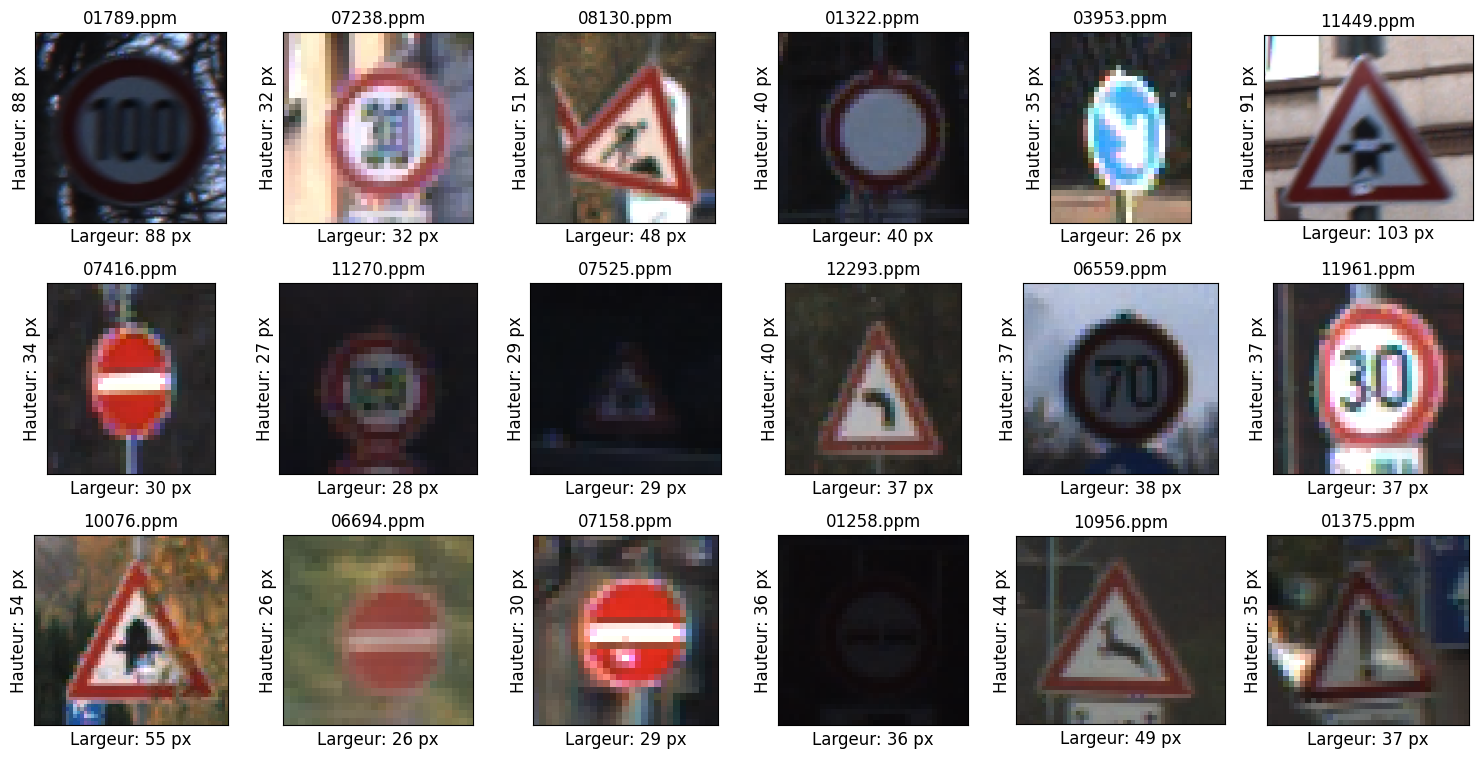

In [6]:
data_test_dir = '../data/Final_Test/Images'
test = pd.read_csv(data_test_dir + '/GT-final_test.test.csv', delimiter=';')
imgs = test["Filename"].values
plt.figure(figsize=(15, 15))
for i in range(1, 19):
    plt.subplot(6,6, i)
    random_img_name = random.choice(imgs)
    random_img_path = f'{data_test_dir}/{random_img_name}'
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(False) 
    plt.title(random_img_name)
    plt.xlabel(f"Largeur: {rand_img.shape[1]} px", fontsize=12) 
    plt.ylabel(f"Hauteur: {rand_img.shape[0]} px", fontsize=12)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

## Construction du modèle

In [7]:
# Construction d'un modèle CNN plus sophistiqué
print(f'Construction du modèle CNN en cours.')

# Initialisation du modèle séquentiel
model = models.Sequential([
    # Première couche d'entrée avec la taille d'image spécifiée et 3 canaux de couleur (RGB)
    layers.Input(shape=(*IMG_SIZE, 3)),
    # Première couche convolutionnelle avec 16 filtres, taille de noyau 3x3, activation ReLU et padding 'same'
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    # Deuxième couche convolutionnelle avec 32 filtres, taille de noyau 3x3, activation ReLU et padding 'same'
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    # Première couche de pooling pour réduire la dimension spatiale, taille de pool 2x2
    layers.MaxPooling2D((2, 2)),
    # Normalisation par lot pour stabiliser et accélérer l'entraînement
    layers.BatchNormalization(axis=-1),

    # Deuxième bloc de couches convolutionnelles et de pooling
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(axis=-1),

    # Troisième bloc de couches convolutionnelles et de pooling
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(axis=-1),
    
    # Aplatir la sortie des couches convolutionnelles pour la passer aux couches denses
    layers.Flatten(),
    # Couche dense avec 1024 neurones et activation ReLU
    layers.Dense(1024, activation='relu'),
    # Normalisation par lot après la couche dense pour stabiliser et accélérer l'entraînement
    layers.BatchNormalization(),
    # Dropout pour réduire le surapprentissage avec un taux de 0.5
    layers.Dropout(0.5),
    # Couche de sortie avec un neurone par classe et activation softmax pour la classification
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compilation du modèle
print(f'Compilation du modèle CNN en cours.')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(f'Compilation terminée.')


Construction du modèle CNN en cours.
Compilation du modèle CNN en cours.
Compilation terminée.


## Génération de donnée pour l'entraînement et la validation

In [8]:
# Préparation des générateurs de données pour l'entraînement et la validation avec augmentation des données
print(f'Génération des données pour l\'entraînement')
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=False,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Générateurs
print(f'Génération des données pour la validation.')
train_generator = train_datagen.flow_from_directory(
    new_train_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    new_test_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical')





Génération des données pour l'entraînement
Génération des données pour la validation.
Found 38508 images belonging to 43 classes.
Found 17819 images belonging to 43 classes.


## Affichage de quelques variantes pour un panneau

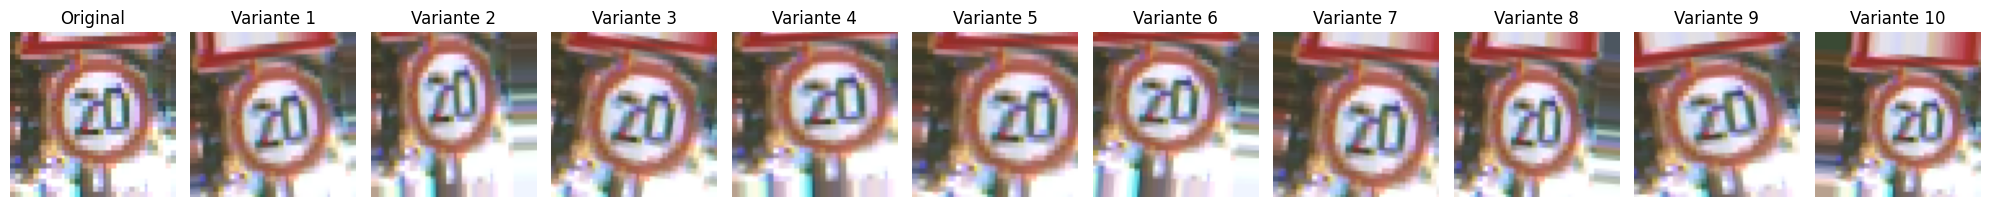

In [9]:
import os
import numpy as np
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import matplotlib.pyplot as plt

# Définir le chemin du dossier contenant les images
image_dir = '../data/gtsrb_split/Images_Train/00000'

# Liste tous les fichiers dans le dossier et filtre les fichiers image
image_files = [f for f in os.listdir(image_dir) if f.endswith('.ppm')]

# Choisir un fichier image aléatoire
random_image_file = random.choice(image_files)
random_image_path = os.path.join(image_dir, random_image_file)

# Charger l'image
img = load_img(random_image_path, target_size=(64, 64)) 
img_array = img_to_array(img)  
img_array = np.expand_dims(img_array, axis=0)  

# Configuration du générateur avec augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=False,
    fill_mode='nearest'
)

# Générer des lots d'images augmentées
it = train_datagen.flow(img_array, batch_size=1)

# Afficher l'image originale et les images augmentées
plt.figure(figsize=(20, 4))
plt.subplot(1, 11, 1)
plt.imshow(np.uint8(img_array[0]))  
plt.title("Original")
plt.axis('off')

for i in range(10):
    plt.subplot(1, 11, i+2)
    batch = next(it) 
    img_aug = batch[0]  
    plt.imshow(np.uint8(img_aug * 255))  
    plt.title("Variante " + str(i+1))
    plt.axis('off')
plt.tight_layout()
plt.show()


## Entraînement du modèle

In [11]:
# Callbacks pour améliorer l'entraînement
checkpoint_cb = ModelCheckpoint('../data/model/projet_model.keras', save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)


# Entraînement du modèle
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

# Sauvegarder l'historique sous forme de JSON
history_path = '../data/json/training_history_V1.json'
with open(history_path, 'w') as f:
    json.dump(history.history, f)
print(f"L'historique d'entraînement a été sauvegardé à {history_path}.")

# Évaluation du modèle
eval_result = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f'Validation loss: {eval_result[0]} - Validation accuracy: {eval_result[1]}')


Epoch 1/30
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 937s 775ms/step - accuracy: 0.5914 - loss: 1.5291 - val_accuracy: 0.9582 - val_loss: 0.1278
Epoch 2/30
   1/1203 ━━━━━━━━━━━━━━━━━━━━ 2:56 147ms/step - accuracy: 1.0000 - loss: 0.0399

C:\Users\guigu\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


1203/1203 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - accuracy: 1.0000 - loss: 0.0399 - val_accuracy: 1.0000 - val_loss: 0.0097
Epoch 3/30
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 210s 174ms/step - accuracy: 0.9523 - loss: 0.1496 - val_accuracy: 0.9663 - val_loss: 0.0995
Epoch 4/30
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 45us/step - accuracy: 1.0000 - loss: 0.0097 - val_accuracy: 0.9630 - val_loss: 0.0679
Epoch 5/30
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 206s 171ms/step - accuracy: 0.9668 - loss: 0.1085 - val_accuracy: 0.9840 - val_loss: 0.0490
Epoch 6/30
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 7/30
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 386s 321ms/step - accuracy: 0.9758 - loss: 0.0814 - val_accuracy: 0.9867 - val_loss: 0.0444
Epoch 8/30
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step - accuracy: 0.9688 - loss: 0.1406 - val_accuracy: 1.0000 - val_loss: 0.0123
Epoch 9/30
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 906s 751ms/step - accuracy: 0.9765 - los

FileNotFoundError: [Errno 2] No such file or directory: '../data/json/training_history_V1.json'

## Visualisation de l'entraînement

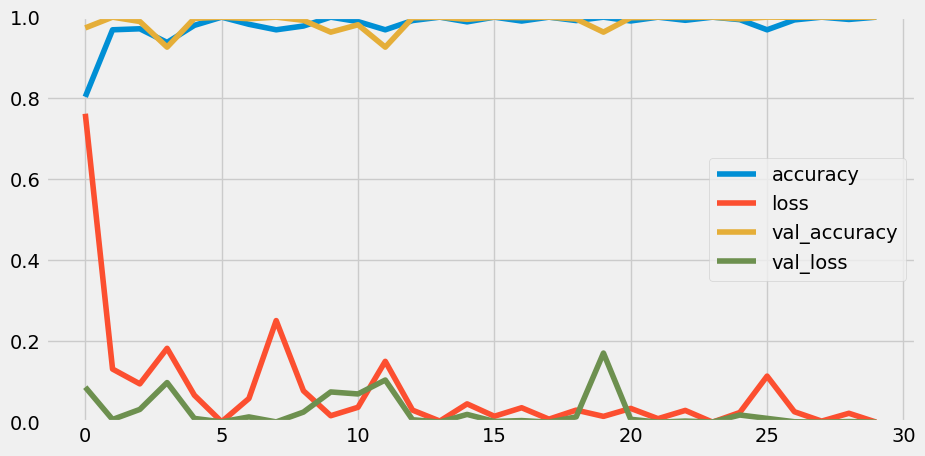

In [82]:
pd.DataFrame(history.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Test du modèle avec plusieurs images prédéfini dans un fichier CSV

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


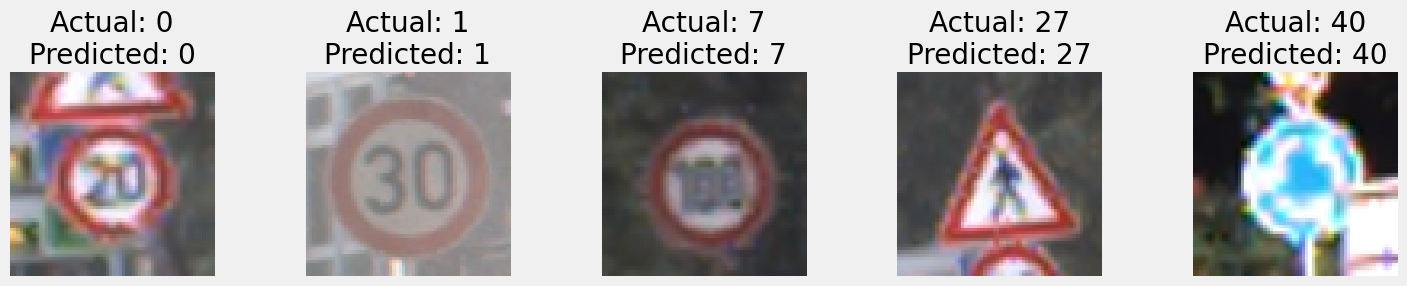

In [107]:

# Charger les images et préparer les données
test = pd.read_csv('../data/Final_Test/Images/image_csv.csv', delimiter=';')
labels = test["ClassId"].values
imgs = test["Filename"].values
data = []

for img in imgs:
    try:
        image = cv2.imread('../data/Final_Test/Images/' + img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        image_fromarray = Image.fromarray(image)
        resize_image = image_fromarray.resize((64, 64))
        data.append(np.array(resize_image))
    except Exception as e:
        print("Error in " + img + ": " + str(e))

X_test = np.array(data) / 255.0

# Charger le modèle et prédire
model = load_model('../data/model/traffic_sign_model.keras')
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Affichage des images sur une seule ligne
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))  

for i, (image, label, prediction) in enumerate(zip(data, labels, predicted_classes)):
    ax = axes[i]
    ax.imshow(image)
    ax.set_title(f'Actual: {label}\nPredicted: {prediction}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Essai du modèle sur un panneau de signalisation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Prédiction : Entrée interdite


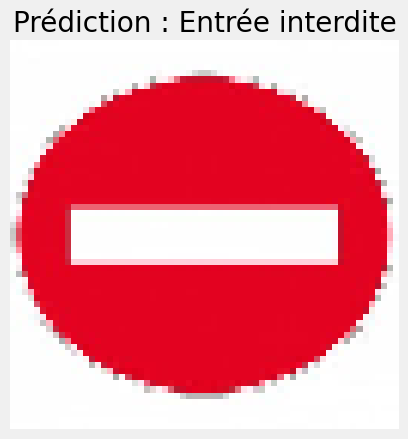

In [117]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt

# Définir la taille de l'image attendue par le modèle
IMG_SIZE = (64, 64) 

# Chemin vers le modèle pré-entraîné et l'image à tester
model_path = '../data/model/projet_model.keras'
img_path = '../data/test_image_png/img.jpg'

# Charger l'image avec la taille attendue par le modèle
img = load_img(img_path, target_size=IMG_SIZE)


# Convertir l'image en tableau numpy
img_array = img_to_array(img)

# Normaliser l'image comme cela a été fait pour les données d'entraînement
img_array = img_array / 255.0

# Ajouter une dimension pour créer un lot d'une seule image
img_array = np.expand_dims(img_array, axis=0)

# Charger le modèle pré-entraîné
model = load_model(model_path)

# Faire la prédiction
predictions = model.predict(img_array)

# Identifier la classe prédite
predicted_class = np.argmax(predictions, axis=1)

# Afficher la classe prédite
print(f'Prédiction : {classes_label[predicted_class[0]]}')

# Afficher l'image chargée
plt.imshow(img)
plt.title(f'Prédiction : {classes_label[predicted_class[0]]}')
plt.axis('off')
plt.show()